# Detecting brain tumor in MRI images
The project is about classifying patients into two groups. The groups are about having a tumor in the brain or not. The data gathered from about 300 patients. They are 300 MRI images from 300 distinct patients(Dataset: [Brain MRI images for brain tumor detection](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection)). Images are labeled as containing the tumor ('YES') and healthy ('NO'). We have to learn these data and be able to classify unseen data accurately.


First of all let's include all the necessary things.

In [1]:
import tensorflow as tf
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


After that, we need to load the dataset. The dataset consists of two separate folders named *train* and *test* which containing training and test data respectively. Each folder has two categories that labeled as *YES* and *NO* meaning, being healthy and having a tumor respectively. 

As we know, the data might not be enough to train a model with many parameters, so we have to somehow make our dataset larger. Using *Data Augmentation* we can modify training data by some simple transformations and achieve more data for training somehow. In this method, the transformations should not change the meaning of the data. For example, if we change the opacity of images and make them too high or too low, even humans could not notice that there was a tumor in the picture or not. So our model couldn't say that either.

Found 253 images belonging to 2 classes.
Found 253 images belonging to 2 classes.


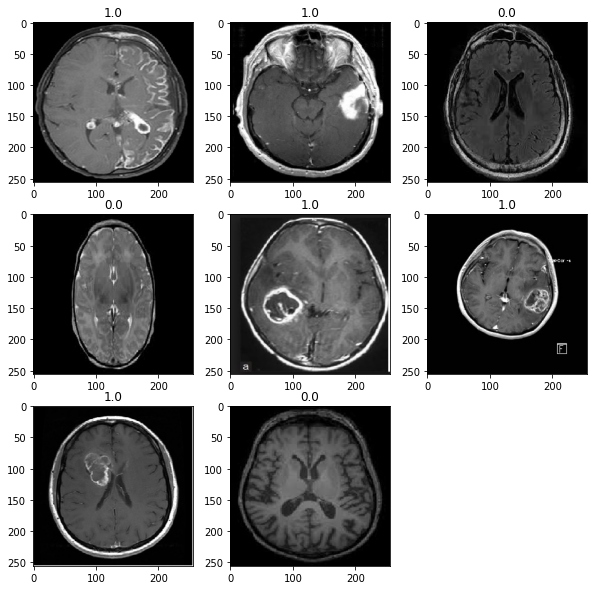

In [5]:
train_data_path = './data/train/'
test_data_path = './data/test/'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2, 
    height_shift_range = 0.2, 
    shear_range = 0.2, 
    zoom_range = 0.2, 
    horizontal_flip = True, 
    vertical_flip =True
    )
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,)
train = train_datagen.flow_from_directory(train_data_path, class_mode='binary', batch_size=8)
test = test_datagen.flow_from_directory(test_data_path, class_mode='binary', batch_size=8)

batchX, batchy = test.next()

plt.figure(figsize=(10,10))
for i in range(8):
    plt.subplot(3,3,i+1)
    plt.imshow(batchX[i])
    plt.title(batchy[i])
plt.show()

As you can see, the tumor is a meaningful feature that exists in these pictures, a tumor has a local definition and could not be understood directly from the opacity of each pixel. Therefore, we have to make some suitable features from these images and then take these features and use them for classification. The other thing is that our data is too low to train a huge network, we only have 300 images, so a better choice is instead of starting from randomly initialized weights of the network, we could just start with a trained weighs for the other task for starting point and then try to converge to a better local minimum for our problem based our few data.

To do so we use a pre-trained InceptionResNetV2 network as a base network which acts as a feature generator for each image. The base network takes the input image and turns it into some good meaningful features that are suitable for classification. after that we design a classifier network that takes the features and makes a decision for each one of them.

In [10]:
base_model = tf.keras.applications.InceptionResNetV2(
        weights='imagenet', 
        input_shape = (200,200,3),
        include_top=False
    )
    
model = tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(128, activation = 'relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               196736    
_________________________________________________________________
batch_normalization_407 (Bat (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 54,534,113
Trainable params: 54,473,313
Non-trainable params: 60,800
_____________________________________

Another good method for preventing overfitting is early stopping. In this method, we say that if the validation error doesn't decrease after some epochs stop the training process and report the best model parameters till now. Using this, we will achieve the highest accuracy in our model.

In [11]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("Tumor_classifier_model.h5", save_best_only=True, verbose = 0),
    tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss', verbose=1),
]

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

history = model.fit(
        train, 
        validation_data=test, 
        epochs = 50, 
        callbacks = [callbacks], 
        verbose = 1
    )

Epoch 1/50
32/32 [==============================] - 29s 355ms/step - loss: 0.6497 - accuracy: 0.7019 - val_loss: 0.6783 - val_accuracy: 0.6364
Epoch 2/50
32/32 [==============================] - 8s 258ms/step - loss: 0.4406 - accuracy: 0.8220 - val_loss: 0.6969 - val_accuracy: 0.6403
Epoch 3/50
32/32 [==============================] - 8s 257ms/step - loss: 0.3247 - accuracy: 0.8693 - val_loss: 0.4149 - val_accuracy: 0.8261
Epoch 4/50
32/32 [==============================] - 8s 259ms/step - loss: 0.2629 - accuracy: 0.9115 - val_loss: 0.5345 - val_accuracy: 0.9012
Epoch 5/50
32/32 [==============================] - 8s 257ms/step - loss: 0.2912 - accuracy: 0.8605 - val_loss: 0.1725 - val_accuracy: 0.9328
Epoch 6/50
32/32 [==============================] - 8s 258ms/step - loss: 0.2236 - accuracy: 0.9173 - val_loss: 0.2169 - val_accuracy: 0.9209
Epoch 7/50
32/32 [==============================] - 8s 258ms/step - loss: 0.2725 - accuracy: 0.8909 - val_loss: 0.1137 - val_accuracy: 0.9565
Epoch

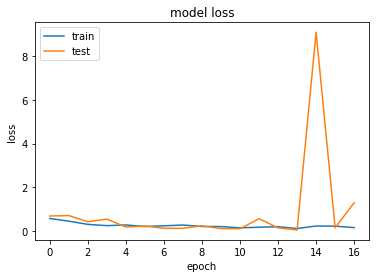

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

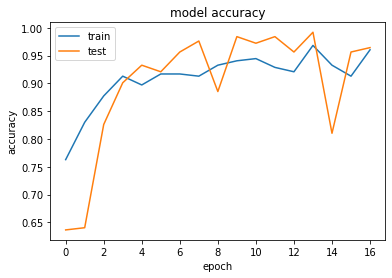

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

As we observed the finally the model achieved about 96% of accuracy in the test dataset but as we don't know the risk of deciding for each patient we can't say how good is this accuracy and this model for those kinds of problems. To know that, we need to have an expert who tells us about the risk and some other statistics such as prior probabilities and the risk of taking each action.